In [ ]:
# Brief description
#
# mini-400 dataset is used
# 400 classes
# 20 unique images per class for training set
# first level augmentation x137 => 2,740 images/class
# 1,096,000 total train images (400 x 2,740)
# rest of the images go to validation set (without first level augmentation)
# 104,096 total validation images

# after 5 epocs top level accuracy on validation set is 0.9

In [1]:
import numpy as np
import os
from random import shuffle
import time
import csv

import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers, losses, activations, applications
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard

# used to download pretrained Inception V3 Keras Model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

#DATA_DIR = "/home/spa/coin-vision/ssd-data/all-68-20190123-keras-no-noise/"
#DATA_DIR = "/home/spa/coin-vision/ssd-data/micro-25-20190204/"
DATA_DIR = "/home/spa/coin-vision/ssd-data/mini-400-20190205/"

MODEL_LABELS_FILE_PATH = DATA_DIR + "labels.txt"
MODEL_FILE_PATH = DATA_DIR + "inception_v3_" + time.strftime("%Y%m%d-%H%M%S") + ".hdf5"

train_epochs=5
ROWS=299
COLS=299

train_batch_size = 64
validation_batch_size = 100



tensorboard_log_dir = DATA_DIR + 'logs/'
tensorboard = TensorBoard(log_dir=tensorboard_log_dir)

print('tensorflow version', tf.__version__)
print('TensorBoard log dir: ', tensorboard_log_dir)
print('MODEL_FILE_PATH: ', MODEL_FILE_PATH)




Using TensorFlow backend.


tensorflow version 1.12.0
TensorBoard log dir:  /home/spa/coin-vision/ssd-data/mini-400-20190205/logs/
MODEL_FILE_PATH:  /home/spa/coin-vision/ssd-data/mini-400-20190205/inception_v3_20190205-101836.hdf5


In [2]:
list_paths = []
for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        list_paths.append(filepath)

In [3]:
list_train = [filepath for filepath in list_paths if "labeled-images-tr/" in filepath]
list_test = [filepath for filepath in list_paths if "labeled-images-tst/" in filepath]

validation_steps = len(list_test) / validation_batch_size # images-in-test / val-batch-size

# TODO: print amount train / test images

In [4]:
train_idg = ImageDataGenerator(
                               vertical_flip=False,
                               horizontal_flip=False,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               rotation_range=20,
                               zoom_range=0.2,
                               shear_range=0.2,
                               preprocessing_function=preprocess_input)

test_idg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tr/',
    target_size=(ROWS, COLS),
    batch_size = train_batch_size
)
test_gen = test_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tst/',
    target_size=(ROWS, COLS),
    batch_size = validation_batch_size,
    shuffle = True
)


Found 1096000 images belonging to 400 classes.
Found 104096 images belonging to 400 classes.


In [5]:
#labels

In [6]:
labels = test_gen.class_indices.items()

# save to file (is used during prediction)
with open(MODEL_LABELS_FILE_PATH, 'w') as outfile:
    w = csv.writer(outfile)
    for key, value in labels:
        w.writerow([key, str(value)])

# load from file (to make sure same labels are used during train & prediction)
with open(MODEL_LABELS_FILE_PATH, mode='r') as infile:
    reader = csv.reader(infile)
    labels = {rows[0]:int(float(rows[1])) for rows in reader}
    
labels = labels.items()    

In [7]:
# get a batch sample from training set generator to show sample images and histogram
x,y = train_gen.next()

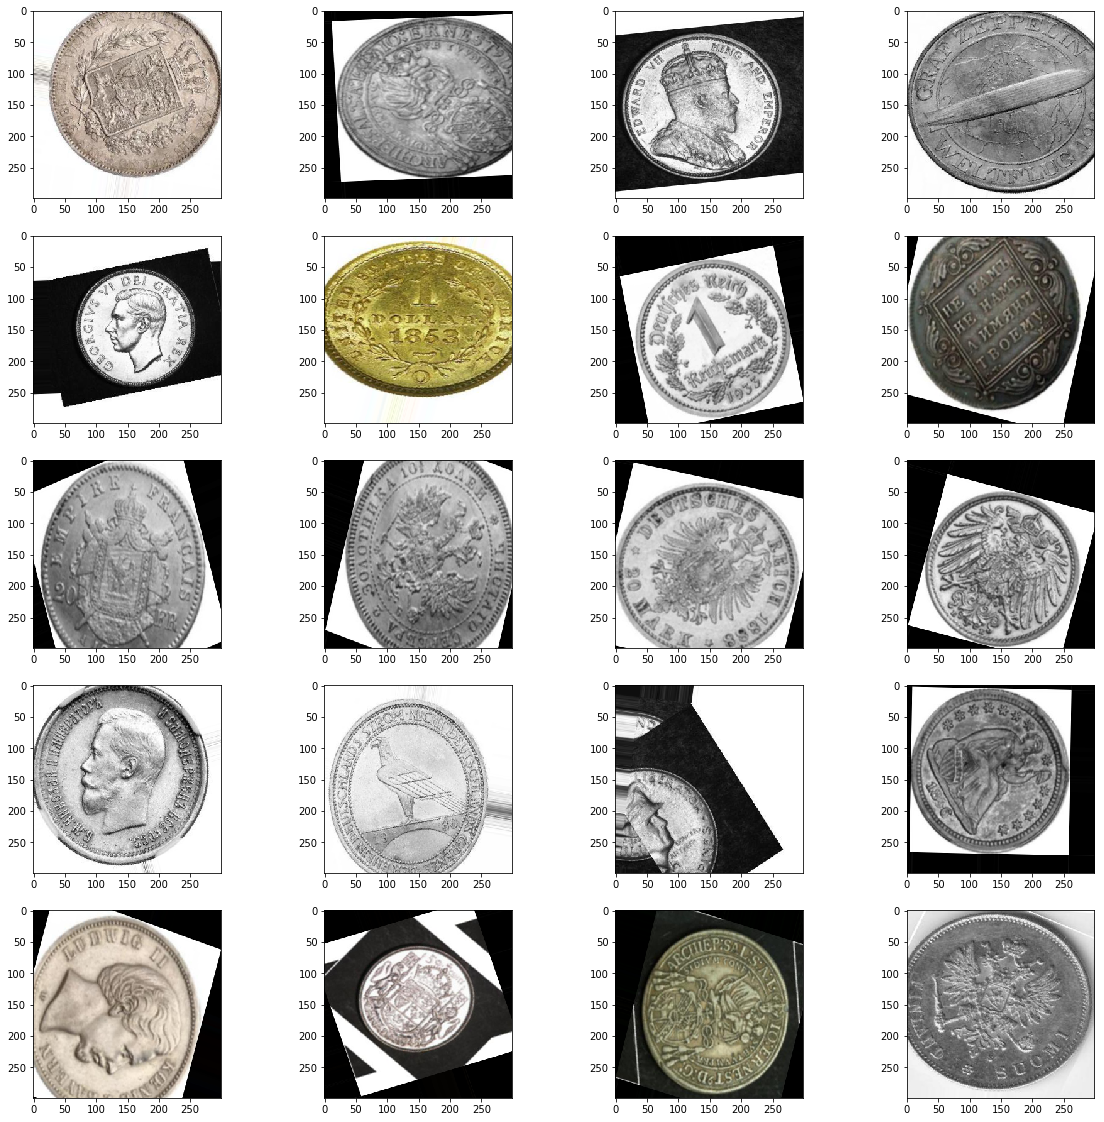

In [8]:
#show some images from train set
# rescale for better view: [-1:1] => [0:255]
img_to_plot_uint8 = (127.5*(x + 1)).astype(np.uint8)
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_to_plot_uint8[i])
plt.show()

show histogram for a train image


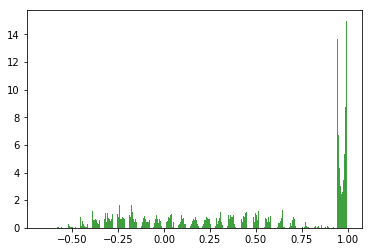

In [9]:
# show histogram for one sample used for training
print('show histogram for a train image')
n, bins, patches = plt.hist(x[0,:,:,1].reshape(ROWS, COLS), 25, density=1, facecolor='green', alpha=0.75)
plt.show()

In [10]:

input_shape = (ROWS, COLS, 3)
nclass = len(labels)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
#add_model.add(Dropout(0.3))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               819600    
Total params: 22,622,384
Trainable params: 22,587,952
Non-trainable params: 34,432
_________________________________________________________________


In [11]:
# LOAD MODEL
#model.load_weights(file_path)

tr_steps_per_epoch = len(list_train) / train_batch_size
print('trainig steps per epoc: ', tr_steps_per_epoch)


checkpoint = ModelCheckpoint(MODEL_FILE_PATH, monitor='acc', verbose=1, save_best_only=False, mode='max')

early = EarlyStopping(monitor="acc", mode="max", patience=5)

callbacks_list = [checkpoint, early, tensorboard] #early

history = model.fit_generator(train_gen, 
                              epochs=train_epochs, 
                              steps_per_epoch=tr_steps_per_epoch,
                              shuffle=True, 
                              verbose=True,
                              validation_data=test_gen,
                              validation_steps=validation_steps, # fix me later if works
                              callbacks=callbacks_list)

trainig steps per epoc:  17125.0
Epoch 1/5
17125/17125 [==============================] - 23480s 1s/step - loss: 0.6590 - acc: 0.8438 - top_k_categorical_accuracy: 0.9198 - val_loss: 0.8536 - val_acc: 0.8300 - val_top_k_categorical_accuracy: 0.9623

Epoch 00001: saving model to /home/spa/coin-vision/ssd-data/mini-400-20190205/inception_v3_20190205-101836.hdf5
Epoch 2/5
17125/17125 [==============================] - 23531s 1s/step - loss: 0.0502 - acc: 0.9836 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.7601 - val_acc: 0.8703 - val_top_k_categorical_accuracy: 0.9685

Epoch 00002: saving model to /home/spa/coin-vision/ssd-data/mini-400-20190205/inception_v3_20190205-101836.hdf5
Epoch 3/5
17125/17125 [==============================] - 23508s 1s/step - loss: 0.0253 - acc: 0.9922 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.6744 - val_acc: 0.8904 - val_top_k_categorical_accuracy: 0.9757

Epoch 00003: saving model to /home/spa/coin-vision/ssd-data/mini-400-20190205/inception_v3_2

In [12]:
# RELOAD MODEL from the file (to make sure we use the same model for test/predictions)
model.load_weights(MODEL_FILE_PATH)


In [13]:
# test_gen_final uses same test data as test_idg. The difference is class_mode='binary' (test_idg uses class_mode='categorical' )
test_gen_final = test_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tst/',
    target_size=(ROWS, COLS),
    batch_size = 100,
    shuffle = False,
    class_mode='binary'
)


Found 104096 images belonging to 400 classes.


In [17]:
steps = 1040
predicts_label_acc = []
y_true_label_acc = []

# TODO: show some images and histogram from test sequence 

for step in range(steps):
    x_test,y_true = test_gen_final.next()
    predicts = model.predict_classes(x_test)
    label_index = {v: k for k,v in labels}
    predicts_label = [label_index[p] for p in predicts]
    y_true_label = [label_index[p] for p in y_true]
    predicts_label_acc.extend(predicts_label)
    y_true_label_acc.extend(y_true_label)
    print("done ", step, " from ", steps)



done  0  from  1040
done  1  from  1040
done  2  from  1040
done  3  from  1040
done  4  from  1040
done  5  from  1040
done  6  from  1040
done  7  from  1040
done  8  from  1040
done  9  from  1040
done  10  from  1040
done  11  from  1040
done  12  from  1040
done  13  from  1040
done  14  from  1040
done  15  from  1040
done  16  from  1040
done  17  from  1040
done  18  from  1040
done  19  from  1040
done  20  from  1040
done  21  from  1040
done  22  from  1040
done  23  from  1040
done  24  from  1040
done  25  from  1040
done  26  from  1040
done  27  from  1040
done  28  from  1040
done  29  from  1040
done  30  from  1040
done  31  from  1040
done  32  from  1040
done  33  from  1040
done  34  from  1040
done  35  from  1040
done  36  from  1040
done  37  from  1040
done  38  from  1040
done  39  from  1040
done  40  from  1040
done  41  from  1040
done  42  from  1040
done  43  from  1040
done  44  from  1040
done  45  from  1040
done  46  from  1040
done  47  from  1040
do

done  378  from  1040
done  379  from  1040
done  380  from  1040
done  381  from  1040
done  382  from  1040
done  383  from  1040
done  384  from  1040
done  385  from  1040
done  386  from  1040
done  387  from  1040
done  388  from  1040
done  389  from  1040
done  390  from  1040
done  391  from  1040
done  392  from  1040
done  393  from  1040
done  394  from  1040
done  395  from  1040
done  396  from  1040
done  397  from  1040
done  398  from  1040
done  399  from  1040
done  400  from  1040
done  401  from  1040
done  402  from  1040
done  403  from  1040
done  404  from  1040
done  405  from  1040
done  406  from  1040
done  407  from  1040
done  408  from  1040
done  409  from  1040
done  410  from  1040
done  411  from  1040
done  412  from  1040
done  413  from  1040
done  414  from  1040
done  415  from  1040
done  416  from  1040
done  417  from  1040
done  418  from  1040
done  419  from  1040
done  420  from  1040
done  421  from  1040
done  422  from  1040
done  423 

done  751  from  1040
done  752  from  1040
done  753  from  1040
done  754  from  1040
done  755  from  1040
done  756  from  1040
done  757  from  1040
done  758  from  1040
done  759  from  1040
done  760  from  1040
done  761  from  1040
done  762  from  1040
done  763  from  1040
done  764  from  1040
done  765  from  1040
done  766  from  1040
done  767  from  1040
done  768  from  1040
done  769  from  1040
done  770  from  1040
done  771  from  1040
done  772  from  1040
done  773  from  1040
done  774  from  1040
done  775  from  1040
done  776  from  1040
done  777  from  1040
done  778  from  1040
done  779  from  1040
done  780  from  1040
done  781  from  1040
done  782  from  1040
done  783  from  1040
done  784  from  1040
done  785  from  1040
done  786  from  1040
done  787  from  1040
done  788  from  1040
done  789  from  1040
done  790  from  1040
done  791  from  1040
done  792  from  1040
done  793  from  1040
done  794  from  1040
done  795  from  1040
done  796 

In [18]:
print(classification_report(predicts_label_acc,y_true_label_acc))


                          precision    recall  f1-score   support

.2IK.GJAAwEAAAEv.vbi7NnS       1.00      0.99      0.99       186
.6jBwcI0UkEAAAErgUVbGgFO       0.93      1.00      0.96       544
.JXBwcI0k4kAAAEllwFQHvlK       0.88      0.98      0.93       209
.LkKbzbiUUMAAAFNDgtXxjda       0.64      0.64      0.64       420
.kfBwcI0dagAAAEqiUAoKiet       0.95      0.89      0.92       128
.m_BwcI0O0UAAAEor.PZY4xr       0.93      0.98      0.95       204
.xQKbzbiG0QAAAFMtGzecg7N       0.99      1.00      0.99       530
094KbzbiZJIAAAFRCdU1_Hq6       0.93      0.92      0.92       250
0E3BwcI0u2YAAAEr2Y9bGgFN       0.87      1.00      0.93       272
0OUKX9ISFTwAAAFW4pEsvhSp       0.99      0.87      0.93       366
0a3BwcI01XYAAAEsLcfkjT7Y       1.00      0.97      0.99       148
0h4KbzbiDZ4AAAFFWhchZfdq       0.97      0.93      0.95       217
0hjBwcI0rc8AAAEnMmJaOLPF       0.95      0.96      0.96       396
0hsK_j7gEmEAAAFBvy4SbU3C       1.00      0.90      0.95       160
0sXBwcI05